<a href="https://colab.research.google.com/github/first-penguin-hub/rabbit_challenge/blob/main/3_5_Seq2Seq(Encoder_Decoder)_sin_cos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq(Encoder-Decoder)モデルを用いたsin-cosの変換

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## データの準備

ここでは、sin関数の値からcos関数の値をSeq2Seqモデルに予測させることを試みる。

入力データとして、`seq_in`を、`seq_out`を出力データ(教師データ)として準備する。

In [2]:
x = np.linspace(-3 * np.pi, 3 * np.pi, 100)
seq_in = np.sin(x)
seq_out = np.cos(x)

`sin`関数の値が入力値、`cos`関数の値が推論したい値となる。

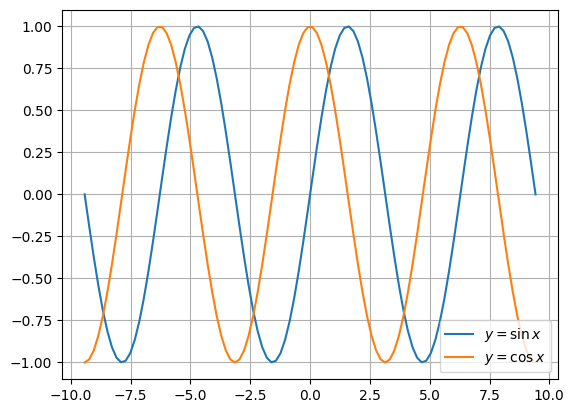

In [3]:
plt.plot(x, seq_in, label='$y=\sin x$')
plt.plot(x, seq_out, label='$y=\cos x$')
plt.legend()
plt.grid()
plt.show()

## モデルの学習

モデルを定義するパラメータを準備する。


*   NUM_ENC_TOKENS: 入力データの次元数
*   NUM_DEC_TOKENS: 出力データの次元数
*   NUM_HIDDEN_PARAMS: 単純RNN層の出力次元数(コンテキストの次元数にもなる)
*   NUM_STEPS: モデルへ入力するデータの時間的なステップ数。



In [4]:
NUM_ENC_TOKENS = 1
NUM_DEC_TOKENS = 1
NUM_HIDDEN_PARAMS = 10
NUM_STEPS = 24

学習を行うためのモデルを定義する。

エンコーダーの出力として、ステート(コンテキスト)のみをデコーダー側へ渡している点に注目。

エンコーダーとデコーダーはコンテキスト以外に繋がりのない分離したモデル構造となっている。

In [5]:
tf.keras.backend.clear_session()

e_input = tf.keras.layers.Input(shape=(NUM_STEPS, NUM_ENC_TOKENS), name='e_input')
_, e_state = tf.keras.layers.SimpleRNN(NUM_HIDDEN_PARAMS, return_state=True, name='e_rnn')(e_input)

d_input = tf.keras.layers.Input(shape=(NUM_STEPS, NUM_DEC_TOKENS), name='d_input')
d_rnn = tf.keras.layers.SimpleRNN(NUM_HIDDEN_PARAMS, return_sequences=True, return_state=True, name='d_rnn')
d_rnn_out, _ = d_rnn(d_input, initial_state=[e_state])

d_dense = tf.keras.layers.Dense(NUM_DEC_TOKENS, activation='linear', name='d_output')
d_output = d_dense(d_rnn_out)

model_train = tf.keras.models.Model(inputs=[e_input, d_input], outputs=d_output)
model_train.compile(optimizer='adam', loss='mean_squared_error')

model_train.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 e_input (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 d_input (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 e_rnn (SimpleRNN)              [(None, 10),         120         ['e_input[0][0]']                
                                 (None, 10)]                                                      
                                                                                                  
 d_rnn (SimpleRNN)              [(None, 24, 10),     120         ['d_input[0][0]',            

モデルの定義に合わせて学習用データを準備する。



*   `ex`: エンコーダーの入力として使用する値。
*   `dx`: デコーダーの入力として渡す値。最終的に出力したい値の1つ前のステップの値。
*   `dy`: 最終的に推論したい値。`dx`と比べて時間的に1ステップ先の値となっている。



In [6]:
n = len(x) - NUM_STEPS
ex = np.zeros((n, NUM_STEPS))
dx = np.zeros((n, NUM_STEPS))
dy = np.zeros((n, NUM_STEPS))

for i in range(0, n):
  ex[i] = seq_in[i:i + NUM_STEPS]
  dx[i, 1:] = seq_out[i:i + NUM_STEPS - 1]
  dy[i] = seq_out[i: i + NUM_STEPS]

ex = ex.reshape(n, NUM_STEPS, 1)
dx = dx.reshape(n, NUM_STEPS, 1)
dy = dy.reshape(n, NUM_STEPS, 1)

学習を行う。

ミニバッチのサイズ: 16
エポック数: 80回

In [7]:
BATCH_SIZE = 16
EPOCHS = 80

history = model_train.fit([ex, dx], dy, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=False)

学習の進行状況をグラフに描画する。収束していることが読み取れる。

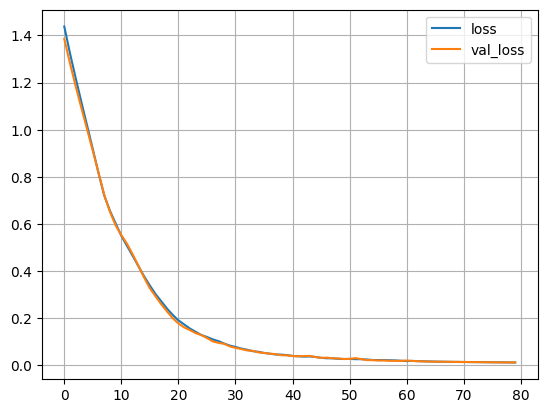

In [8]:
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss, label='loss')

loss = history.history['val_loss']
plt.plot(np.arange(len(loss)), loss, label='val_loss')

plt.grid()
plt.legend()
plt.show()

## 推論用モデルの準備

推論を行うためのモデルを構築する。

デコーダーにコンテキストの入力がある点に注意。Seq2Seqの推論時には逐次、それまでに推論した結果を次の推論に用いる。ステート(コンテキスト)は、このときモデルの外に保持しておき、デコーダーの入力として渡される。

In [9]:
model_pred_e = tf.keras.models.Model(inputs=[e_input], outputs=[e_state])

pred_d_input = tf.keras.layers.Input(shape=(1, 1))
pred_d_state_in = tf.keras.layers.Input(shape=(NUM_HIDDEN_PARAMS))

pred_d_output, pred_d_state = d_rnn(pred_d_input, initial_state=[pred_d_state_in])
pred_d_output = d_dense(pred_d_output)


pred_d_model = tf.keras.Model(inputs=[pred_d_input, pred_d_state_in], outputs=[pred_d_output, pred_d_state])

### 推論用関数の定義

モデルの推論を行う関数を準備する。

関数内では、

1.   エンコーダーで初期のコンテキストを取得する。
2.   デコーダーで初期のコンテキストと1文字目を元に推論を開始する。
3.   デコーダーから最終出力とコンテキストが出力され、次のステップでのデコーダーのコンテキスト･文字



In [10]:
def predict(input_data):
  state_value = model_pred_e.predict(input_data)
  _dy = np.zeros((1, 1, 1))

  output_data = []
  for i in range(0, NUM_STEPS):
    y_output, state_value = pred_d_model.predict([_dy, state_value])

    output_data.append(y_output[0, 0, 0])
    _dy[0, 0, 0] = y_output

  return output_data


### 推論の実行

1/1 [==============================] - 0s 26ms/step


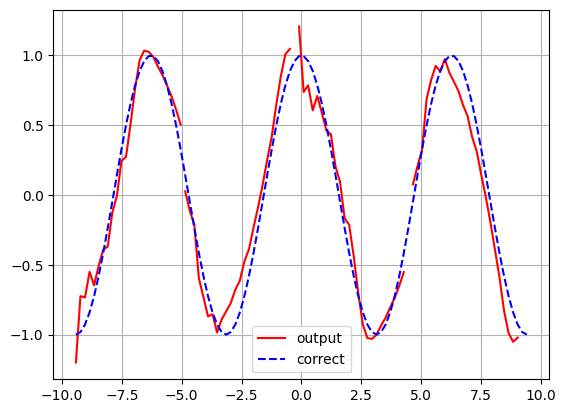

In [11]:
init_points = [0, 24, 49, 74]

for i in init_points:
  _x = ex[i : i + 1]
  _y = predict(_x)

  if i == 0:
    plt.plot(x[i : i + NUM_STEPS], _y, color="red", label='output')
  else:
    plt.plot(x[i : i + NUM_STEPS], _y, color="red")

plt.plot(x, seq_out, color = 'blue', linestyle = "dashed", label = 'correct')
plt.grid()
plt.legend()
plt.show()